In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [3]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



#### prepping for mapping 

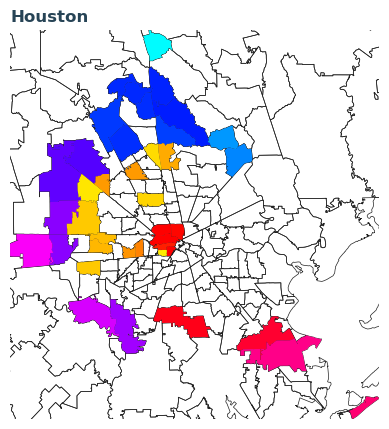

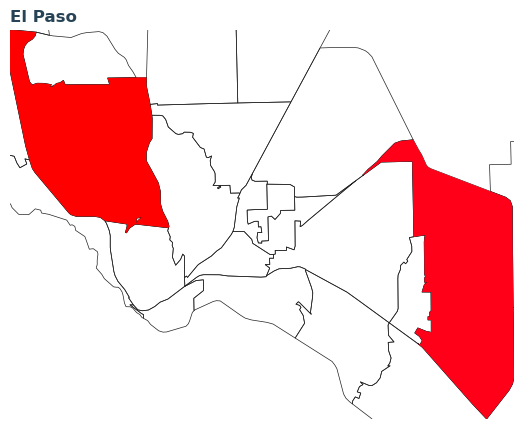

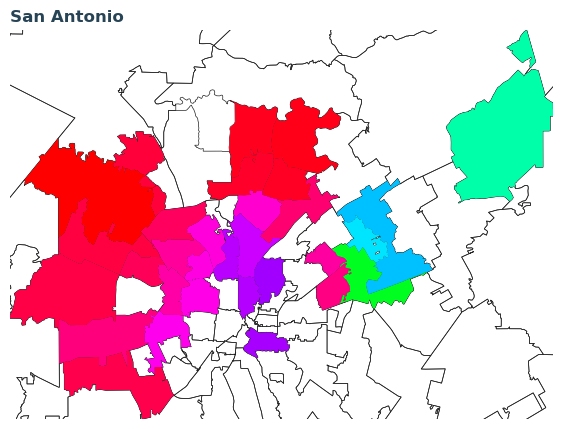

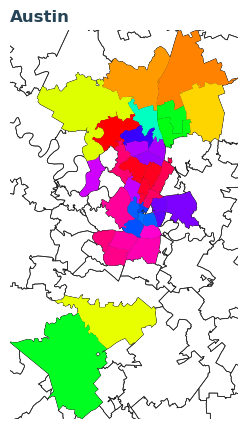

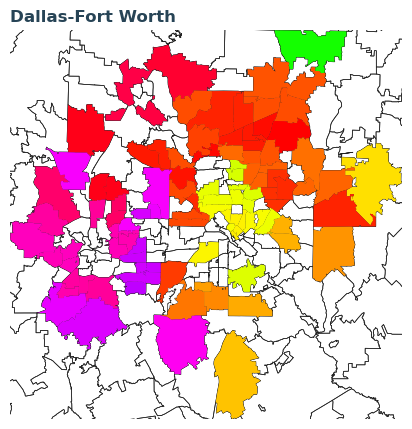

In [4]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = different_metros[metro].total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro)
    plt.show()

In [5]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    6:['zori_ssa'],
    7:['zori_ssa'],
    12:['zori_ssa'],
    18:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_7_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_12_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
                       'zori_ssa_12_diff_lag_6']]


In [6]:
X_vals = ['zori_ssa_6_month_shift',
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
                       'zori_ssa_12_diff_lag_6']
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted

Performing Grid Search with alphas of: [0.3, 0.6, 1]


In [7]:
test['pred_6_month_growth'] = test['pred'] - test['zori_ssa_6_month_shift']
test['actual_6_month_growth'] = test['zori_ssa'] - test['zori_ssa_6_month_shift']

In [8]:
test['pred_6_month_growth_per'] = test['pred_6_month_growth']/test['zori_ssa_6_month_shift']
test['actual_6_month_growth_per'] = test['actual_6_month_growth']/test['zori_ssa_6_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_6_month_shift']
test['month'] = test['Time'].dt.month


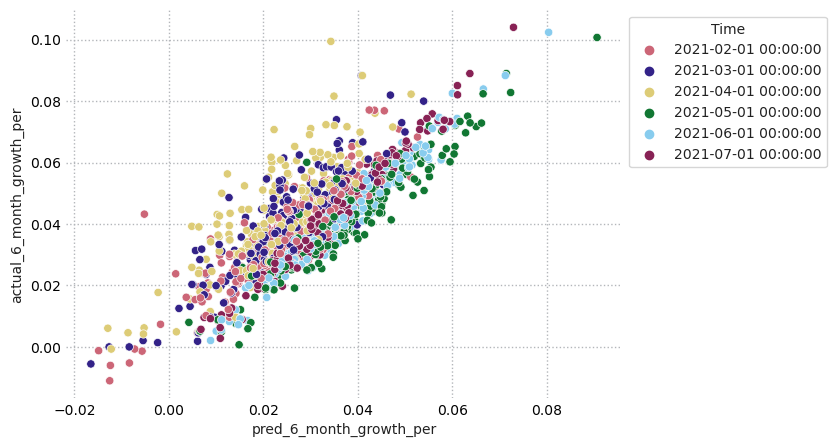

In [9]:
g = sns.scatterplot(data = test, x = 'pred_6_month_growth_per', 
                y = 'actual_6_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

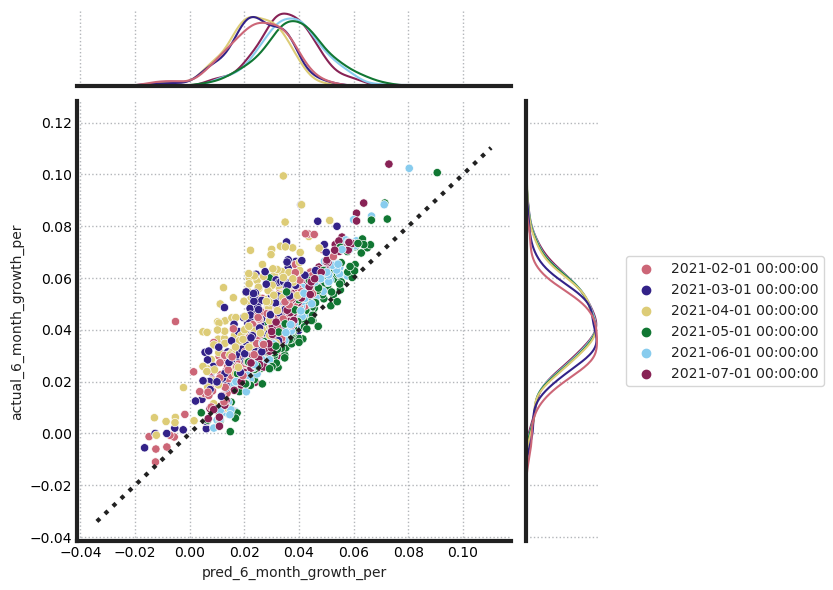

In [10]:
g = sns.JointGrid(data=test, x = 'pred_6_month_growth_per', 
                y = 'actual_6_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

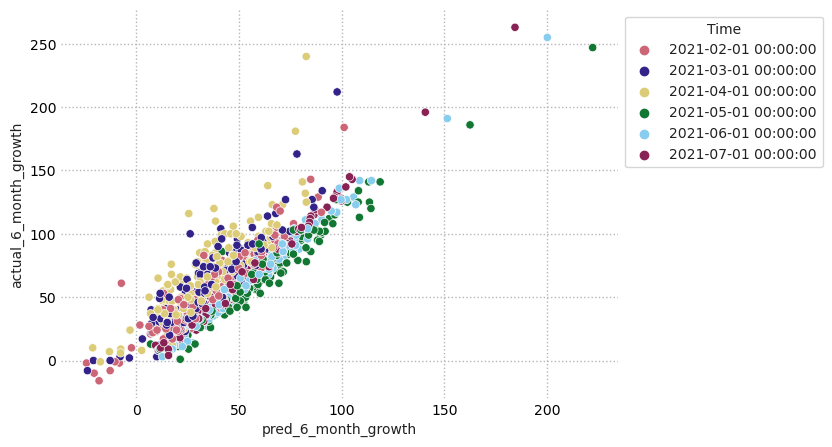

In [11]:
g = sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
               hue = 'Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))

plt.show()

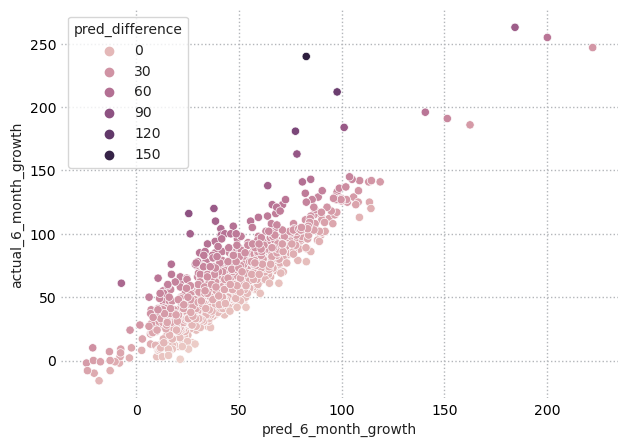

In [12]:
sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
               hue = 'pred_difference')
plt.show()

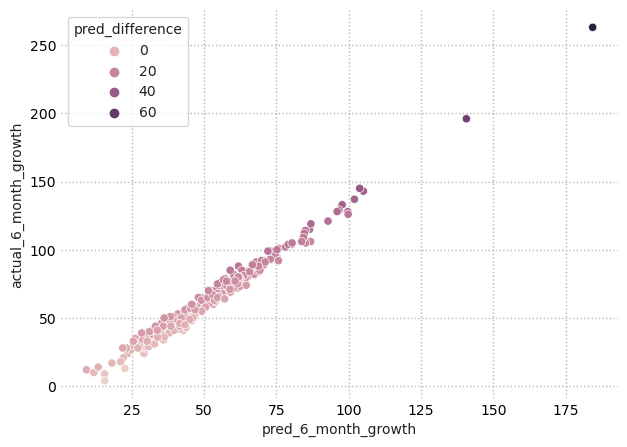

In [13]:
sns.scatterplot(data = test[test['month']==7], x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
               hue = 'pred_difference')
plt.show()

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


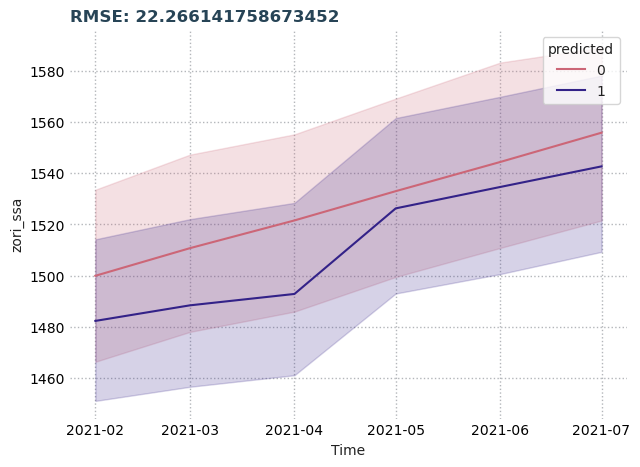

In [14]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

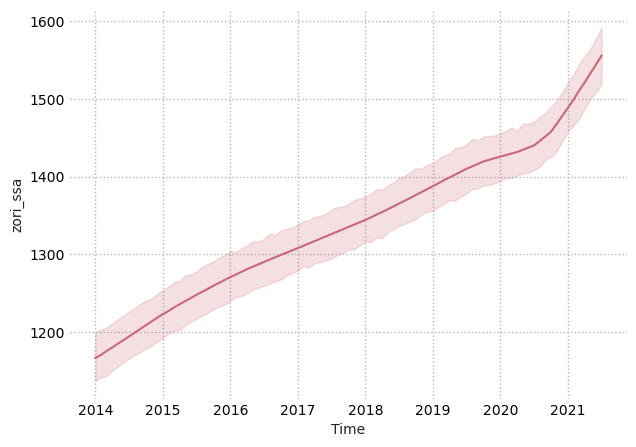

In [15]:
sns.lineplot(data = zri,  x = 'Time',y = y_val)
plt.show()

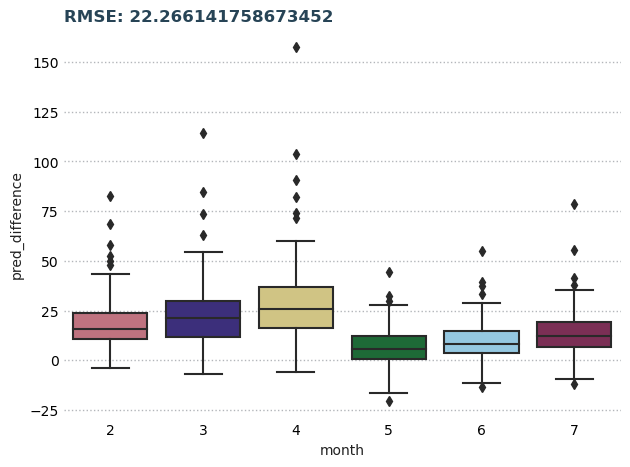

In [16]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [17]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

features       coefs   coefs_abs
0   zori_ssa_6_month_shift  239.694140  239.694140
1   zori_ssa_1_diff__lag_6   17.752829   17.752829
2    zori_ssa_6_diff_lag_6   -5.475895    5.475895
3  zori_ssa_12_month_shift    0.440057    0.440057

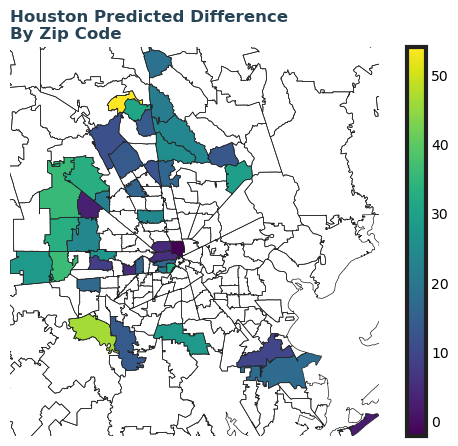

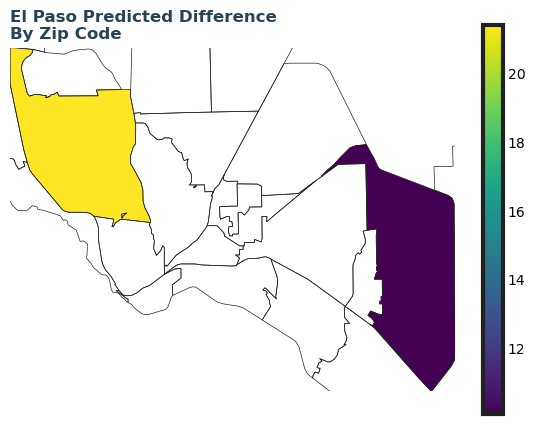

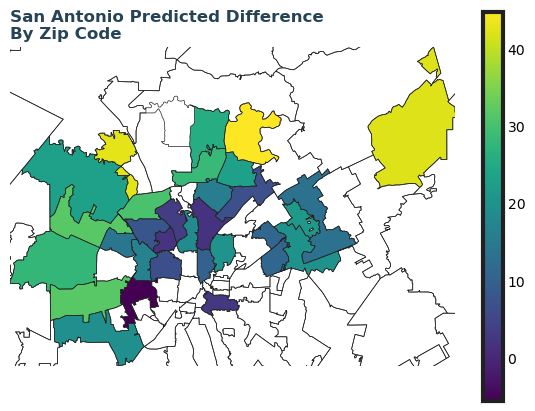

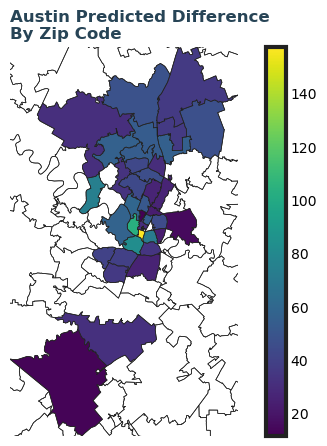

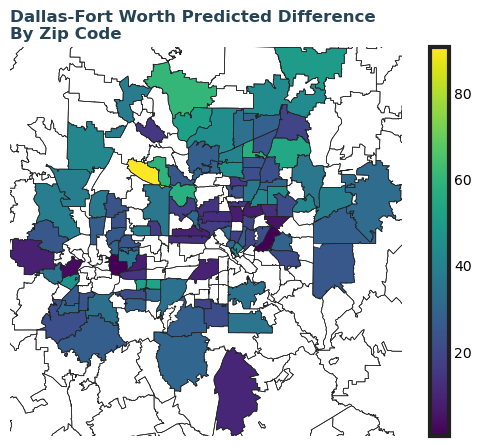

In [18]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted Difference\nBy Zip Code')
    plt.show()

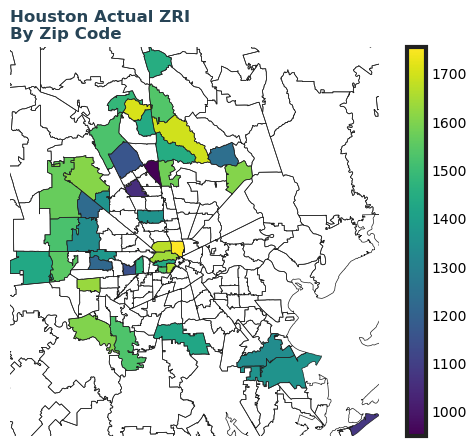

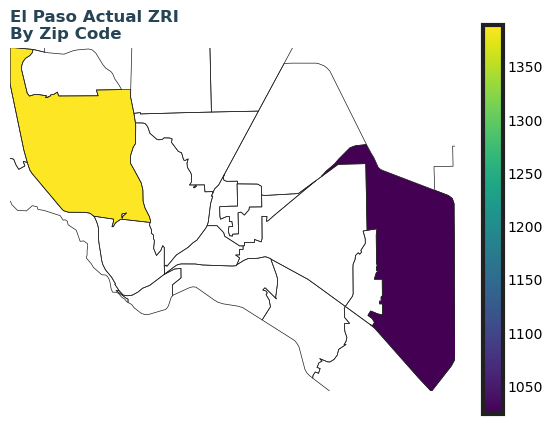

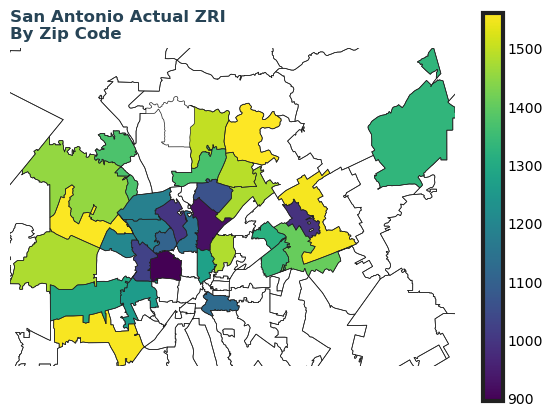

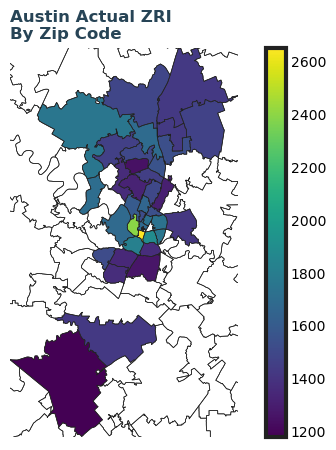

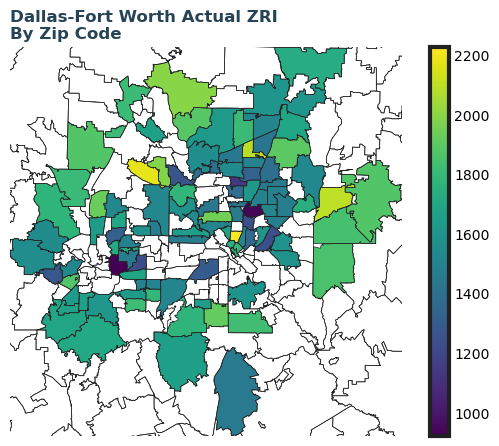

In [19]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["zori_ssa"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual ZRI\nBy Zip Code')
    plt.show()

In [20]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    6:['zori_ssa'],
    7:['zori_ssa'],
    12:['zori_ssa'],
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_7_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_12_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_6','zori_ssa_6_diff_lag_6']]

In [21]:
X_vals = ['zori_ssa_6_month_shift', 'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_6','zori_ssa_6_diff_lag_6'
                       ]
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted

Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


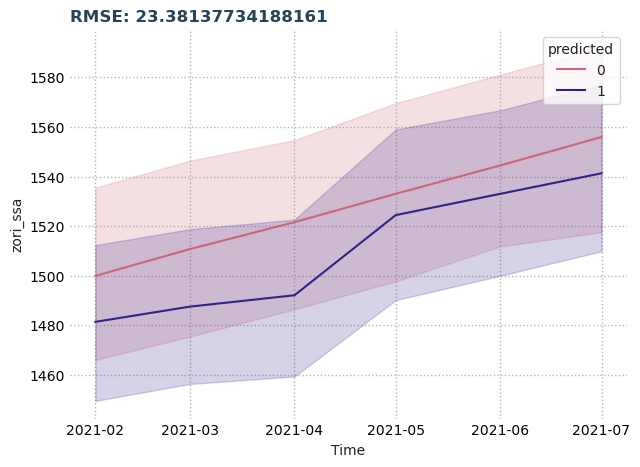

In [22]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

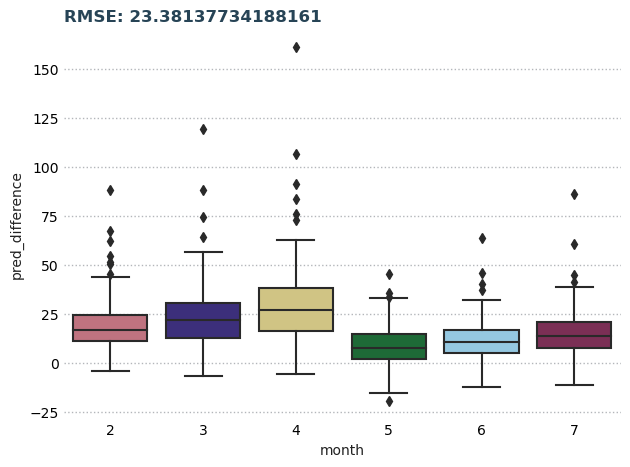

In [23]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [24]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

features       coefs   coefs_abs
0   zori_ssa_6_month_shift  241.497739  241.497739
1    zori_ssa_1_diff_lag_6   17.754476   17.754476
2    zori_ssa_6_diff_lag_6   -5.345365    5.345365
3  zori_ssa_12_month_shift    0.490066    0.490066

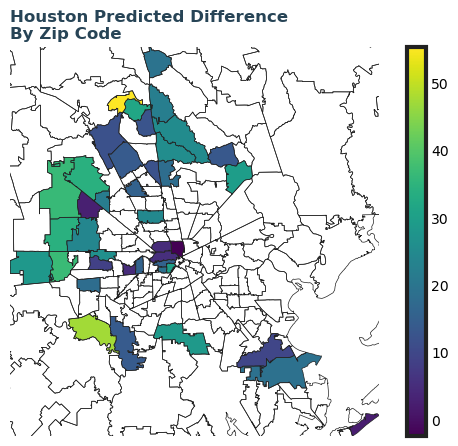

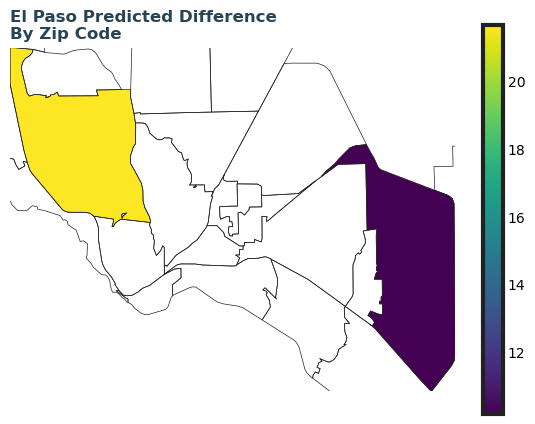

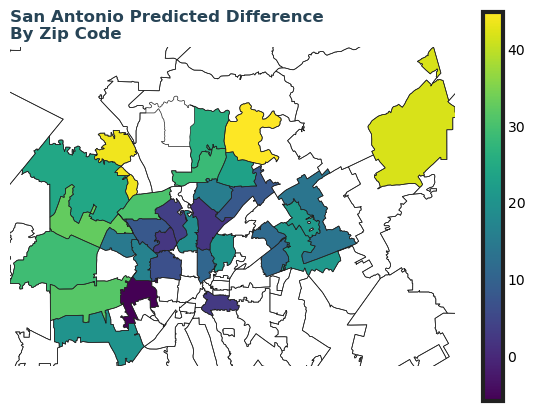

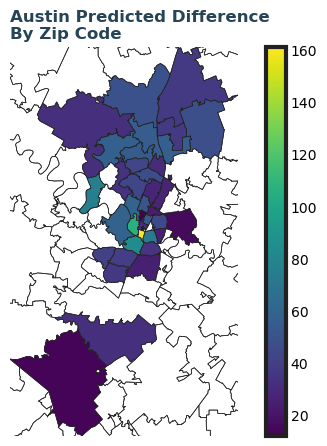

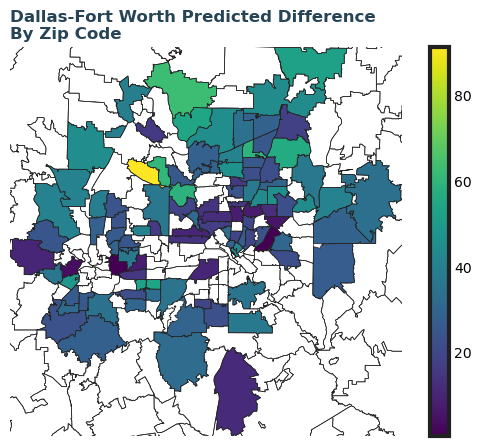

In [25]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted Difference\nBy Zip Code')
    plt.show()

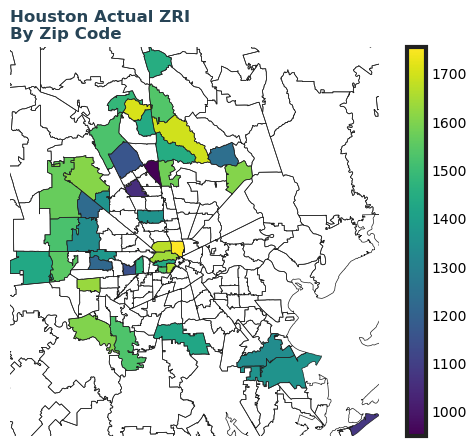

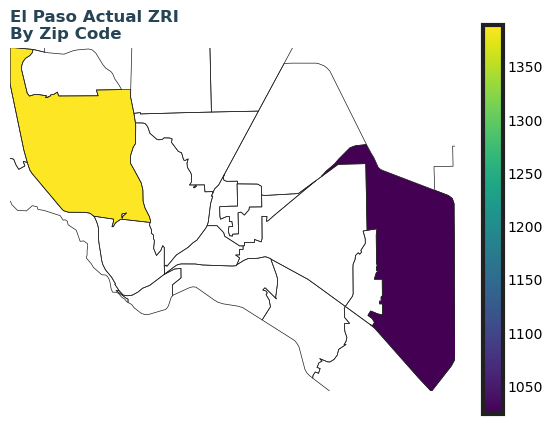

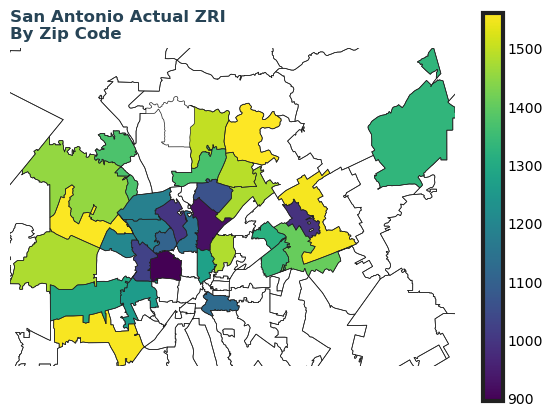

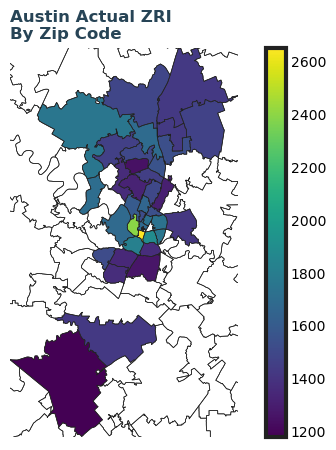

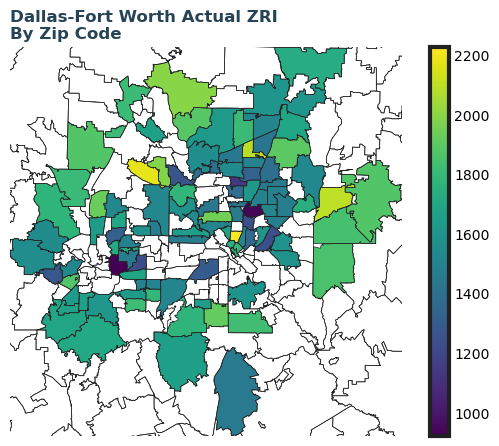

In [26]:
map_ = test[test['Time'].dt.month==4]
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["zori_ssa"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual ZRI\nBy Zip Code')
    plt.show()

### now 12 month lag

In [27]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa', 'zori_ssa_12_month_shift',
       'zori_ssa_13_month_shift', 'zori_ssa_18_month_shift',
       'zori_ssa_24_month_shift','zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
                      'zori_ssa_12_diff_lag_12']]

In [28]:
X_vals = ['zori_ssa_12_month_shift',
       'zori_ssa_13_month_shift', 'zori_ssa_18_month_shift',
       'zori_ssa_24_month_shift','zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
                      'zori_ssa_12_diff_lag_12'
                       ]
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
transformer = ColumnTransformer([("Cat", 
                                  OneHotEncoder(handle_unknown = 'ignore'), 
                                  cat_feats_)], remainder='passthrough')
X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted


Performing Grid Search with alphas of: [0.3, 0.6, 1]


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


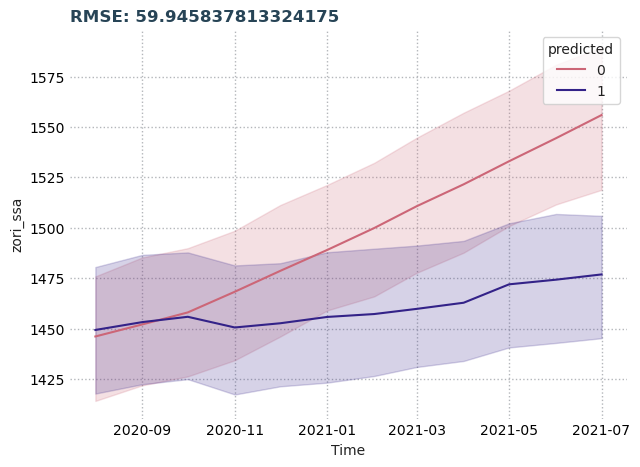

In [29]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

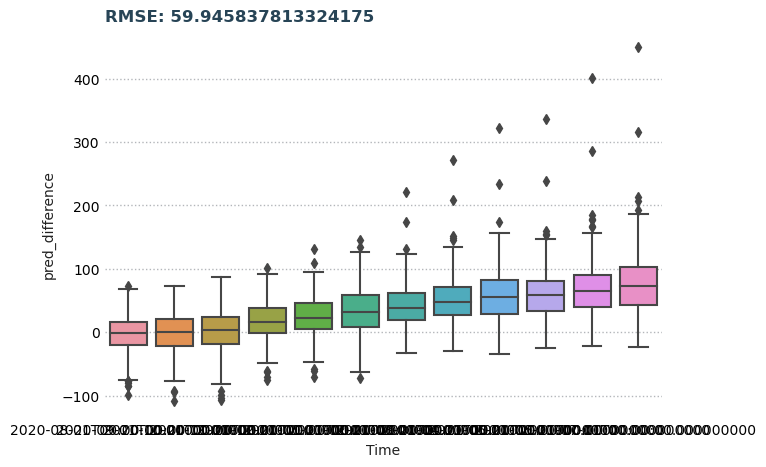

In [30]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [31]:
test

Time  zip_code  zori_ssa  zori_ssa_12_month_shift  \
0    2020-08-01     77494    1370.0                   1350.0   
1    2020-09-01     77494    1374.0                   1352.0   
2    2020-10-01     77494    1378.0                   1354.0   
3    2020-11-01     77494    1387.0                   1355.0   
4    2020-12-01     77494    1395.0                   1356.0   
...         ...       ...       ...                      ...   
2575 2021-03-01     78252    1545.0                   1459.0   
2576 2021-04-01     78252    1555.0                   1464.0   
2577 2021-05-01     78252    1565.0                   1468.0   
2578 2021-06-01     78252    1575.0                   1473.0   
2579 2021-07-01     78252    1585.0                   1477.0   

      zori_ssa_13_month_shift  zori_ssa_18_month_shift  \
0                      1348.0                   1338.0   
1                      1350.0                   1340.0   
2                      1352.0                   1342.0   
3                      1354.0                   1344.0   
4                      1355.0                   1346.0   
...                       ...                      ...   
2575                   1455.0                   1440.0   
2576                   1459.0                   1442.0   
2577                   1464.0                   1445.0   
2578                   1468.0                   1447.0   
2579                   1473.0                   1450.0   

      zori_ssa_24_month_shift  zori_ssa_1_diff_lag_12  zori_ssa_6_diff_lag_12  \
0                      1331.0                     2.0                    12.0   
1                      1332.0                     2.0                    12.0   
2                      1332.0                     2.0                    12.0   
3                      1334.0                     1.0                    11.0   
4                      1335.0                     1.0                    10.0   
...                       ...                     ...                     ...   
2575                   1431.0                     4.0                    19.0   
2576                   1432.0                     5.0                    22.0   
2577                   1434.0                     4.0                    23.0   
2578                   1435.0                     5.0                    26.0   
2579                   1437.0                     4.0                    27.0   

      zori_ssa_12_diff_lag_12  pred_difference         pred  month  
0                        19.0       -10.351068  1380.351068      8  
1                        20.0        -8.437358  1382.437358      9  
2                        22.0        -6.626791  1384.626791     10  
3                        21.0         9.302501  1377.697499     11  
4                        21.0        15.647812  1379.352188     12  
...                       ...              ...          ...    ...  
2575                     28.0        43.319189  1501.680811      3  
2576                     32.0        41.457255  1513.542745      4  
2577                     34.0        56.428628  1508.571372      5  
2578                     38.0        54.566695  1520.433305      6  
2579                     40.0        69.538067  1515.461933      7  

[2580 rows x 13 columns]

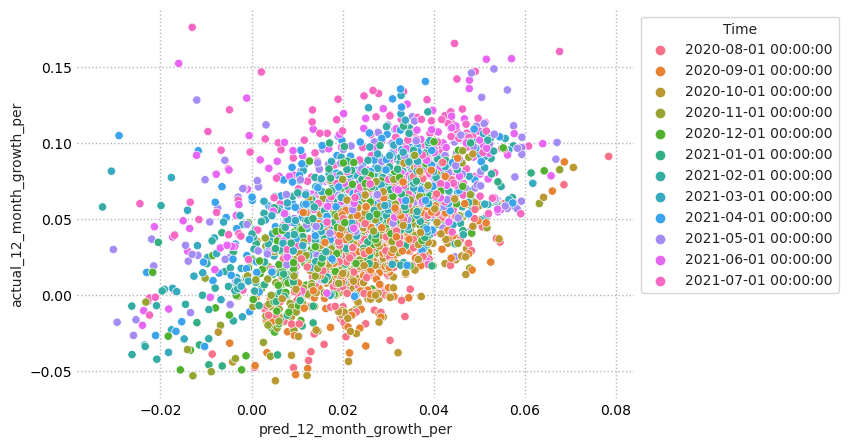

In [32]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']
# test['month'] = test['Time'].dt.month

g = sns.scatterplot(data = test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

In [33]:
import matplotlib.patches as mpatches

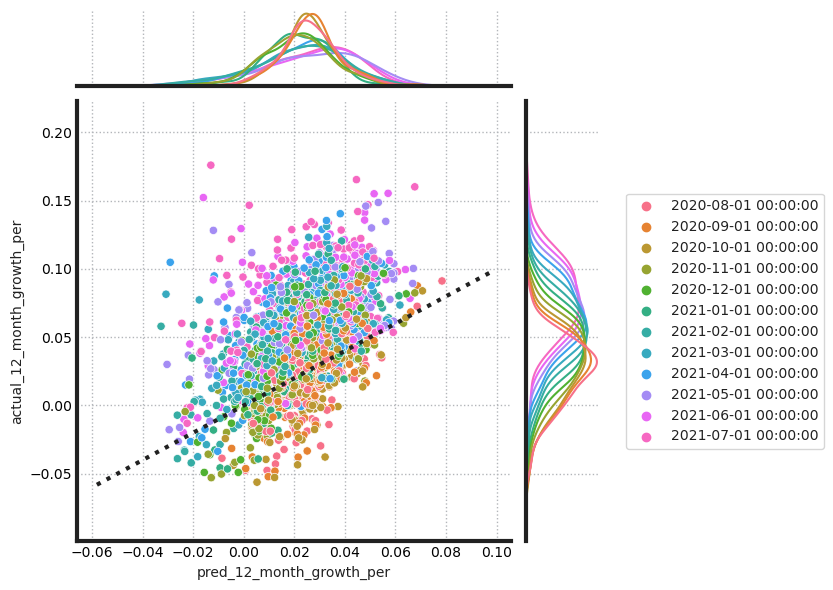

In [34]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()


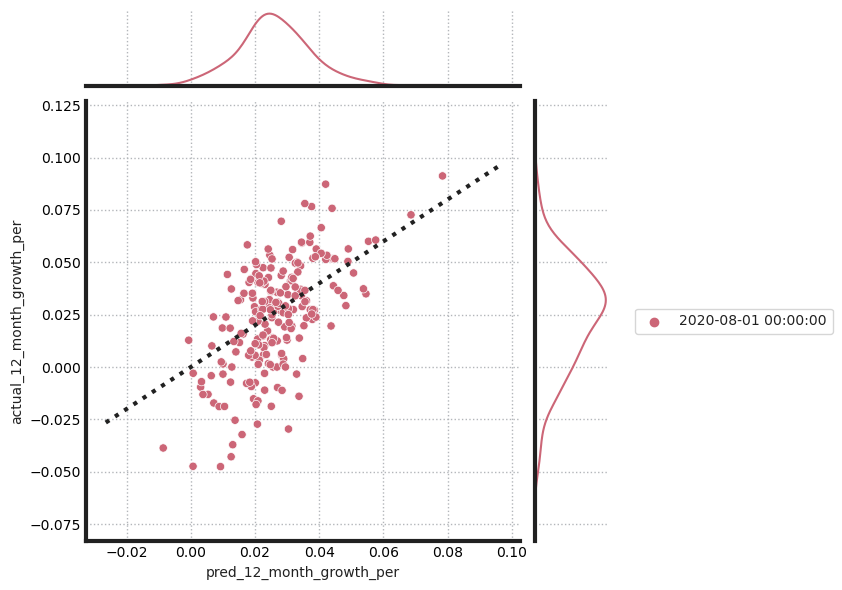

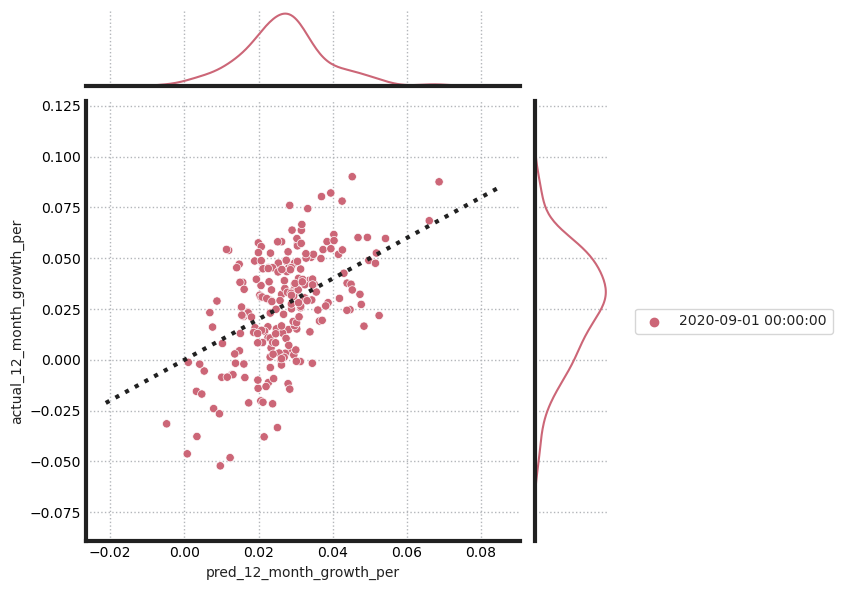

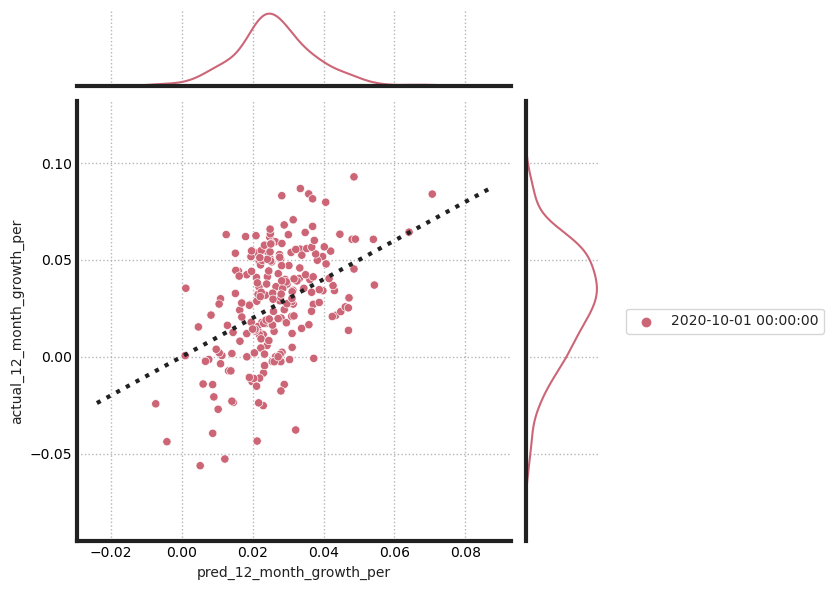

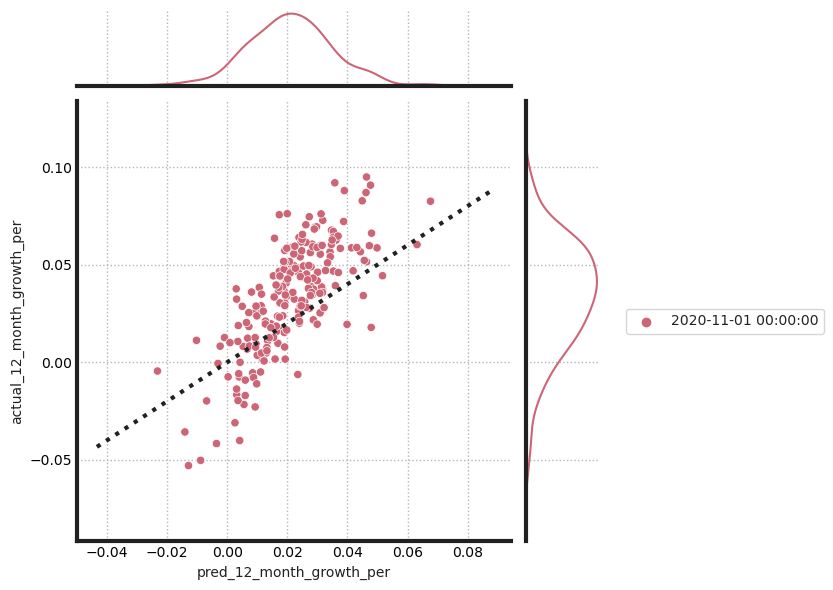

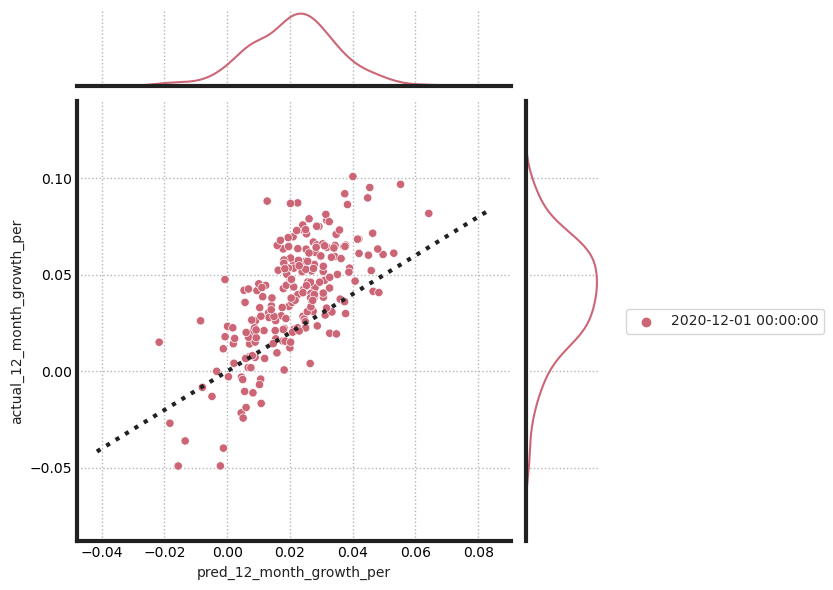

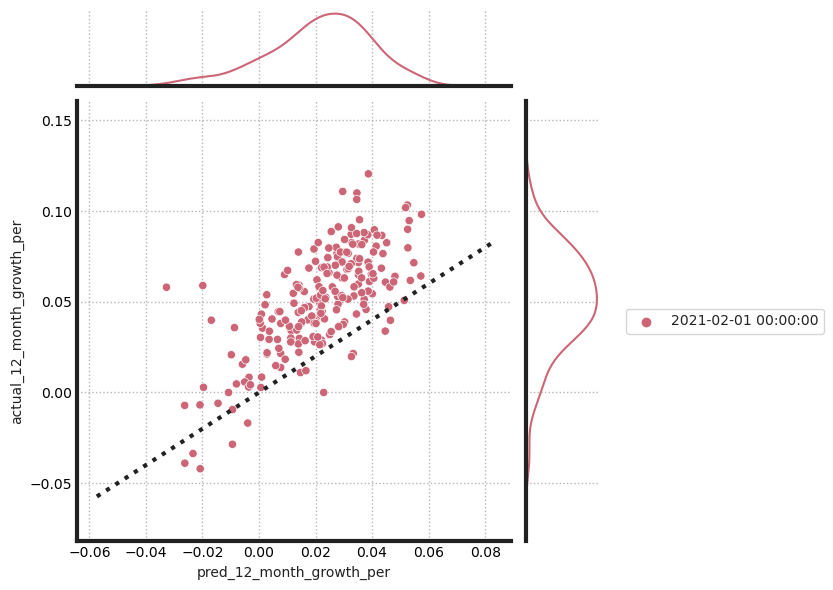

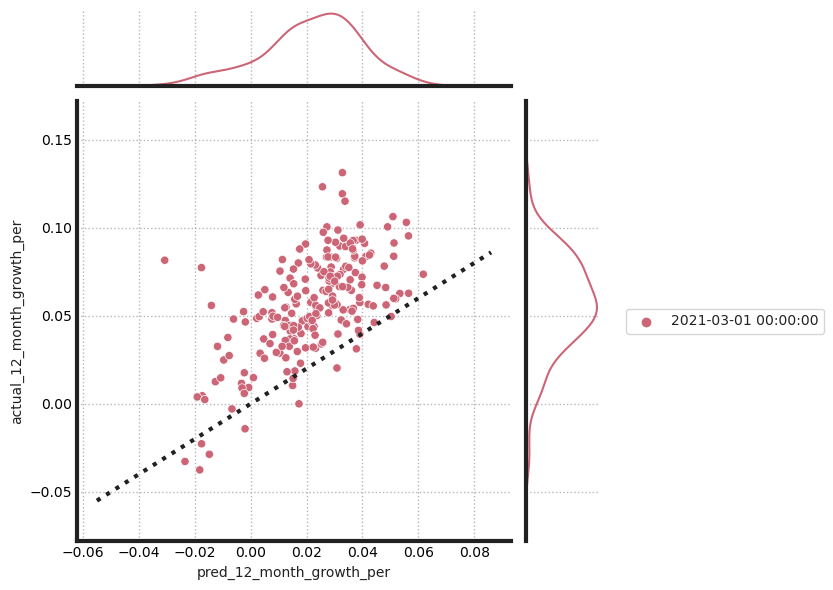

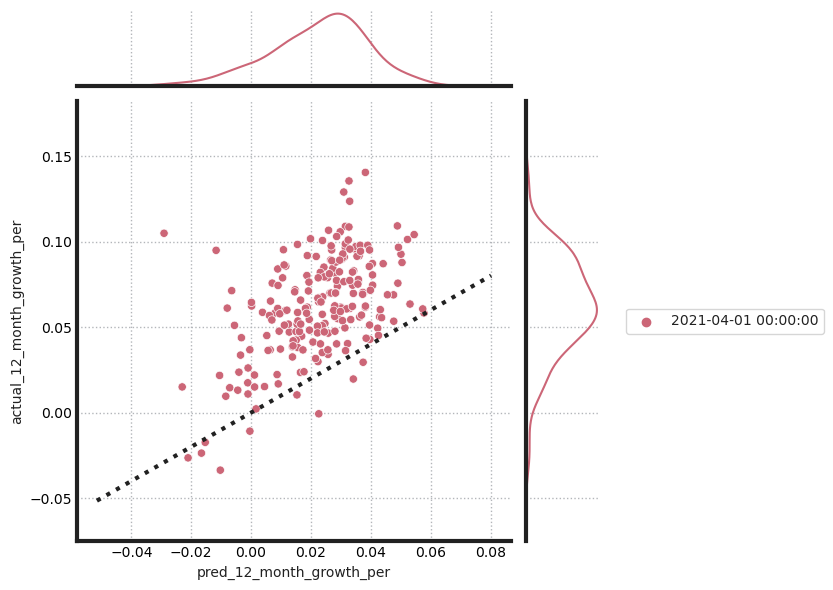

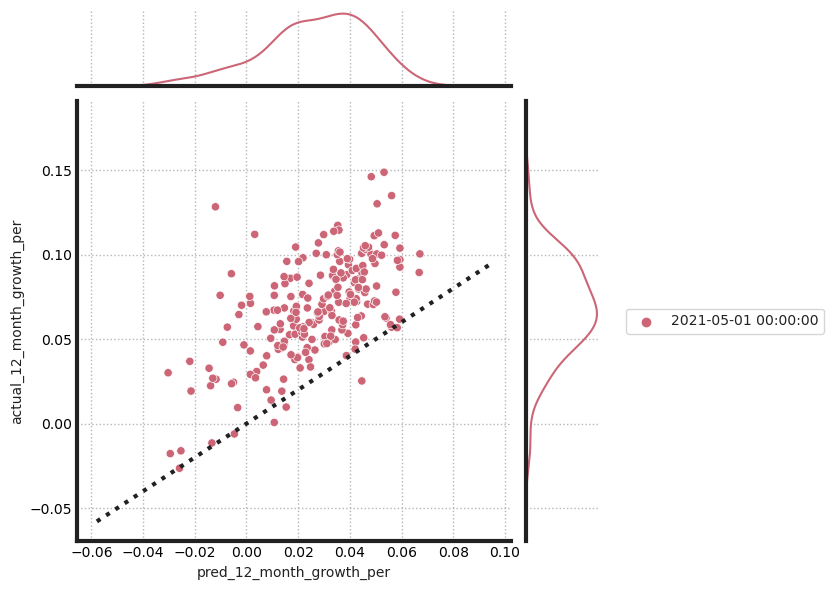

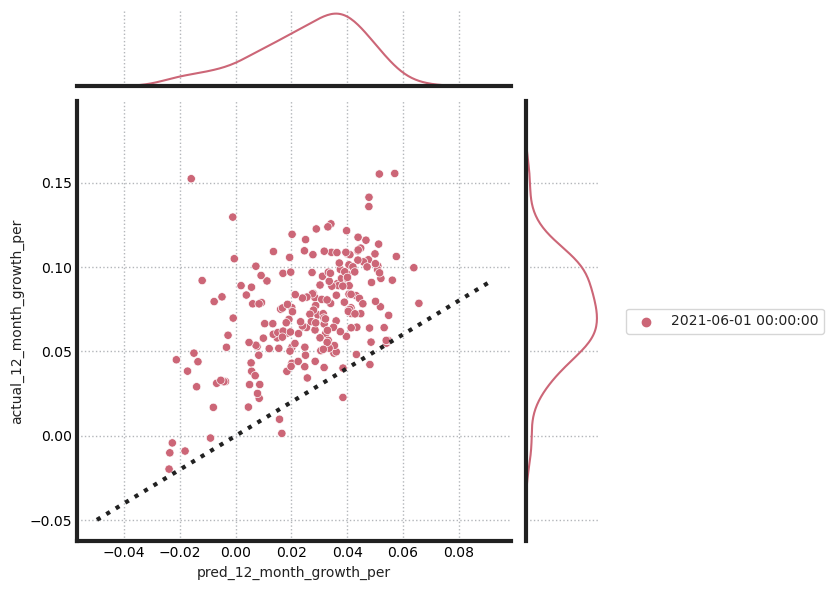

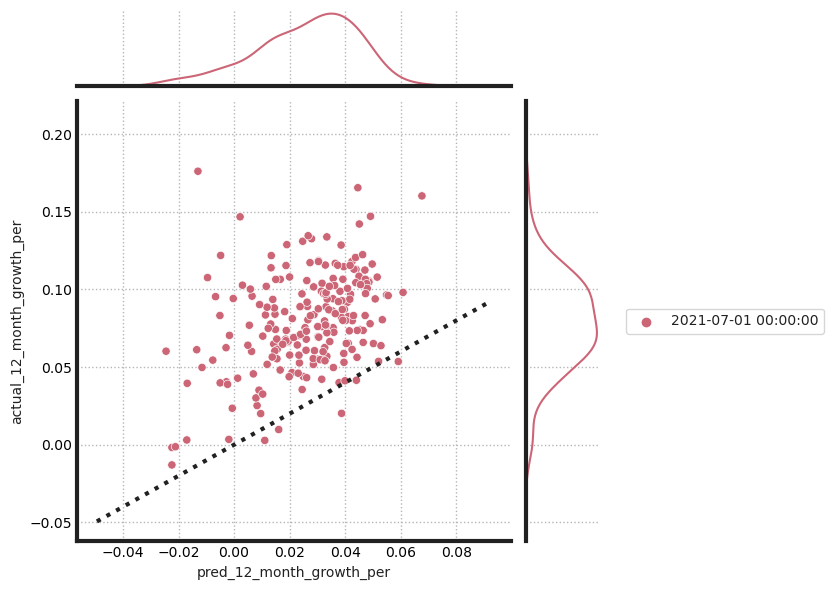

In [45]:

for month in test.Time.unique():
    g = sns.JointGrid(data=test[test['Time']==month], x = 'pred_12_month_growth_per', 
                    y = 'actual_12_month_growth_per', hue='Time',
                     )


    g.plot_joint(sns.scatterplot,)
    g.plot_marginals(sns.kdeplot,legend=False)

    g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')
    g.fig.suptitle("")
    plt.show()

In [44]:
test.Time.unique()

array(['2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')